In [2]:
"""
lowess: Locally linear regression
==================================

Implementation of the LOWESS algorithm in n dimensions.

References
=========
[HTF] Hastie, Tibshirani and Friedman (2008). The Elements of Statistical
Learning; Chapter 6

[Cleveland79] Cleveland (1979). Robust Locally Weighted Regression and Smoothing
Scatterplots. J American Statistical Association, 74: 829-836.

"""
import numpy as np
import numpy.linalg as la

# Kernel functions:
def epanechnikov(xx, **kwargs):
    """
    The Epanechnikov kernel estimated for xx values at indices idx (zero
    elsewhere)

    Parameters
    ----------
    xx: float array
        Values of the function on which the kernel is computed. Typically,
        these are Euclidean distances from some point x0 (see do_kernel)

    Notes
    -----
    This is equation 6.4 in HTF chapter 6

    """
    l = kwargs.get('l', 1.0)
    ans = np.zeros(xx.shape)
    xx_norm = xx / l
    idx = np.where(xx_norm <= 1)
    ans[idx] = 0.75 * (1 - xx_norm[idx]  ** 2)
    return ans


def tri_cube(xx, **kwargs):
    """
    The tri-cube kernel estimated for xx values at indices idx (zero
    elsewhere)

    Parameters
    ----------
    xx: float array
        Values of the function on which the kernel is computed. Typically,
        these are Euclidean distances from some point x0 (see do_kernel)

    idx: tuple
        An indexing tuple pointing to the coordinates in xx for which the
        kernel value is estimated. Default: None (all points are used!)

    Notes
    -----
    This is equation 6.6 in HTF chapter 6
    """
    ans = np.zeros(xx.shape)
    idx = np.where(xx <= 1)
    ans[idx] = (1 - np.abs(xx[idx]) ** 3) ** 3
    return ans


def bi_square(xx, **kwargs):
    """
    The bi-square weight function calculated over values of xx

    Parameters
    ----------
    xx: float array

    Notes
    -----
    This is the first equation on page 831 of [Cleveland79].
    """
    ans = np.zeros(xx.shape)
    idx = np.where(xx < 1)
    ans[idx] = (1 - xx[idx] ** 2) ** 2
    return ans


def do_kernel(x0, x, l=1.0, kernel=epanechnikov):
    """
    Calculate a kernel function on x in the neighborhood of x0

    Parameters
    ----------
    x: float array
       All values of x
    x0: float
       The value of x around which we evaluate the kernel
    l: float or float array (with shape = x.shape)
       Width parameter (metric window size)
    kernel: callable
        A kernel function. Any function with signature: `func(xx)`
    """
    # xx is the norm of x-x0. Note that we broadcast on the second axis for the
    # nd case and then sum on the first to get the norm in each value of x:
    xx = np.sqrt(np.sum(np.power(x - x0[:, np.newaxis], 2), 0))
    return kernel(xx, l=l)


def lowess(x, y, x0, deg=1, kernel=epanechnikov, l=1, robust=False,):
    """
    Locally smoothed regression with the LOWESS algorithm.

    Parameters
    ----------
    x: float n-d array
       Values of x for which f(x) is known (e.g. measured). The shape of this
       is (n, j), where n is the number the dimensions and j is the
       number of distinct coordinates sampled.

    y: float array
       The known values of f(x) at these points. This has shape (j,)

    x0: float or float array.
        Values of x for which we estimate the value of f(x). This is either a
        single scalar value (only possible for the 1d case, in which case f(x0)
        is estimated for just that one value of x), or an array of shape (n, k).

    deg: int
        The degree of smoothing functions. 0 is locally constant, 1 is locally
        linear, etc. Default: 1.

    kernel: callable
        A kernel function. {'epanechnikov', 'tri_cube', 'bi_square'}

    l: float or float array with shape = x.shape
       The metric window size for the kernel

    robust: bool
        Whether to apply the robustification procedure from [Cleveland79], page
        831


    Returns
    -------
    The function estimated at x0.

    Notes
    -----
    The solution to this problem is given by equation 6.8 in Hastie
    Tibshirani and Friedman (2008). The Elements of Statistical Learning
    (Chapter 6).

    Example
    -------
    >>> import lowess as lo
    >>> import numpy as np

    # For the 1D case:
    >>> x = np.random.randn(100)
    >>> f = np.cos(x) + 0.2 * np.random.randn(100)
    >>> x0 = np.linspace(-1, 1, 10)
    >>> f_hat = lo.lowess(x, f, x0)
    >>> import matplotlib.pyplot as plt
    >>> fig, ax = plt.subplots(1)
    >>> _ = ax.scatter(x, f)
    >>> _ = ax.plot(x0, f_hat, 'ro')

    # 2D case (and more...)
    >>> x = np.random.randn(2, 100)
    >>> f = -1 * np.sin(x[0]) + 0.5 * np.cos(x[1]) + 0.2*np.random.randn(100)
    >>> x0 = np.mgrid[-1:1:.1, -1:1:.1]
    >>> x0 = np.vstack([x0[0].ravel(), x0[1].ravel()])
    >>> f_hat = lo.lowess(x, f, x0, kernel=lo.tri_cube)
    >>> from mpl_toolkits.mplot3d import Axes3D
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111, projection='3d')
    >>> _ = ax.scatter(x[0], x[1], f)
    >>> _ = ax.scatter(x0[0], x0[1], f_hat, color='r')
    """
    if robust:
        # We use the procedure described in Cleveland1979
        # Start by calling this function with robust set to false and the x0
        # input being equal to the x input:
        y_est = lowess(x, y, x, kernel=epanechnikov, l=l, robust=False)
        resid = y_est - y
        median_resid = np.nanmedian(np.abs(resid))
        # Calculate the bi-cube function on the residuals for robustness
        # weights:
        robustness_weights = bi_square(resid / (6 * median_resid))

    # For the case where x0 is provided as a scalar:
    if not np.iterable(x0):
       x0 = np.asarray([x0])
    ans = np.zeros(x0.shape[-1])
    # We only need one design matrix for fitting:
    B = [np.ones(x.shape[-1])]
    for d in range(1, deg+1):
        B.append(x ** deg)

    B = np.vstack(B).T
    for idx, this_x0 in enumerate(x0.T):
        # This is necessary in the 1d case (?):
        if not np.iterable(this_x0):
            this_x0 = np.asarray([this_x0])
        # Different weighting kernel for each x0:
        W = np.diag(do_kernel(this_x0, x, l=l, kernel=kernel))
        # XXX It should be possible to calculate W outside the loop, if x0 and
        # x are both sampled in some regular fashion (that is, if W is the same
        # matrix in each iteration). That should save time.

        if robust:
            # We apply the robustness weights to the weighted least-squares
            # procedure:
            robustness_weights[np.isnan(robustness_weights)] = 0
            W = np.dot(W, np.diag(robustness_weights))
        #try:
        # Equation 6.8 in HTF:
        BtWB = np.dot(np.dot(B.T, W), B)
        BtW = np.dot(B.T, W)
        # Get the params:
        beta = np.dot(np.dot(la.pinv(BtWB), BtW), y.T)
        # We create a design matrix for this coordinat for back-predicting:
        B0 = [1]
        for d in range(1, deg+1):
            B0 = np.hstack([B0, this_x0 ** deg])
        B0 = np.vstack(B0).T
        # Estimate the answer based on the parameters:
        ans[idx] += np.dot(B0, beta)
    # If we are trying to sample far away from where the function is
    # defined, we will be trying to invert a singular matrix. In that case,
    # the regression should not work for you and you should get a nan:
        #except la.LinAlgError :
        #    ans[idx] += np.nan
    return ans.T


In [11]:
x = np.random.randn(100)
f = np.cos(x) + 0.2 * np.random.randn(100)
x0 = np.linspace(-1,1,10)
f_hat = lowess(x, f, x0, l=np.linspace(0.1, 1, 100))
f_hat2 = lowess(x, f, x0, l=1)

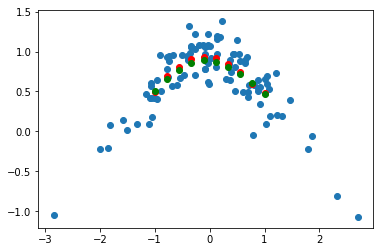

In [12]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1)
ax.scatter(x,f)
ax.plot(x0,f_hat,'ro')
ax.plot(x0, f_hat2, 'go')
plt.show()

In [6]:
x = np.random.randn(2, 100)
f = -1 * np.sin(x[0]) + 0.5 * np.cos(x[1]) + 0.2*np.random.randn(100)
x0 = np.mgrid[-1:1:.1, -1:1:.1]
x0 = np.vstack([x0[0].ravel(), x0[1].ravel()])
f_hat = lowess(x, f, x0, kernel=tri_cube)

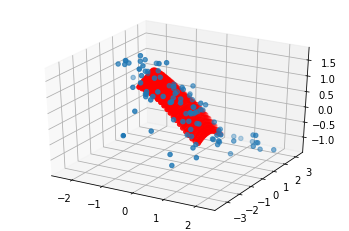

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(x[0], x[1], f)
_ = ax.scatter(x0[0], x0[1], f_hat, color='r')